0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

In [1]:
!pip install tensorflow-gpu==2.0.0-rc0

     |████████████████████████████████| 380.5MB 39kB/s 
     |████████████████████████████████| 501kB 50.3MB/s 
     |████████████████████████████████| 4.3MB 51.0MB/s 


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

In [0]:
output_class = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1LPQ8bvtV0PoStg2wzEbZlauR-qnrreUf'
downloaded = drive.CreateFile({'id':"1LPQ8bvtV0PoStg2wzEbZlauR-qnrreUf"})   # replace the id with id of file you want to access
downloaded.GetContentFile('fer2013.csv') 
# model_vgg = tf.keras.models.load_model('HPE-part1-VGG16_try3.h5')

data = pd.read_csv('fer2013.csv')

In [11]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [0]:
# def x_reshape(df):
#   temp = list() 
#   print(f'Total elements : {df.shape[0]}')
#   for i in range(df.pixels.shape[0]):
#     z1 = np.reshape([int(i)/255.0 for i in list( (df.pixels.iloc[i]).split())], newshape = (48,48,1) )
#     temp.append(z1)
#   return np.array(temp)


In [18]:
# data.Usage.unique()
# train = data[data.Usage == 'Training']

# validation = data[data.Usage == 'PublicTest']
# test = data[data.Usage == 'PrivateTest']

X_train = np.array(list(map(str.split, data[data.Usage =='Training'].pixels)) , np.float32).reshape((data[data.Usage =='Training'].pixels.shape[0],48,48,1))
X_val = np.array(list(map(str.split, data[data.Usage =='PublicTest'].pixels)) , np.float32).reshape((data[data.Usage =='PublicTest'].pixels.shape[0],48,48,1))
X_test = np.array(list(map(str.split, data[data.Usage =='PrivateTest'].pixels)) , np.float32).reshape((data[data.Usage =='PrivateTest'].pixels.shape[0],48,48,1))

print(f'train.shape : {X_train.shape}')
print(f'validation.shape : {X_val.shape}')
print(f'test.shape : {X_test.shape}')

train.shape : (28709, 48, 48, 1)
validation.shape : (3589, 48, 48, 1)
test.shape : (3589, 48, 48, 1)


In [21]:
from keras.utils import np_utils

y_train = np_utils.to_categorical(data[data.Usage =='Training'].emotion , 7)
y_val = np_utils.to_categorical(data[data.Usage =='PublicTest'].emotion, 7)
y_test = np_utils.to_categorical(data[data.Usage =='PrivateTest'].emotion, 7)

print(f'train.shape : {y_train.shape}')
print(f'validation.shape : {y_val.shape}')
print(f'test.shape : {y_test.shape}')


Using TensorFlow backend.


train.shape : (28709, 7)
validation.shape : (3589, 7)
test.shape : (3589, 7)


In [0]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import Sequential


In [0]:
def fer2013(input_shape = (48,48,1), classes = 7):
  
  # Image shape 48,48
  input_layer = layers.Input(shape=input_shape, name  = 'Input')
  grp1_1 = layers.Conv2D(64, kernel_size=5, activation='relu', padding='SAME')(input_layer)
  grp1_1 = layers.BatchNormalization()(grp1_1)
  grp1_2 = layers.Conv2D(64, kernel_size=5, activation='relu', padding='SAME')(grp1_1)
  grp1_2 = layers.BatchNormalization()(grp1_2)
  grp1_3 = layers.MaxPool2D(pool_size = (2,2), )(grp1_2)
  grp1_4 = layers.Dropout(0.3)(grp1_3)

  # Image shape 24,24
  grp2_1 = layers.Conv2D(128, kernel_size=5, activation='relu', padding='SAME')(grp1_4)
  grp2_1 = layers.BatchNormalization()(grp2_1)
  grp2_2 = layers.Conv2D(128, kernel_size=5, activation='relu', padding='SAME')(grp2_1)
  grp2_2 = layers.BatchNormalization()(grp2_2)
  grp2_3 = layers.MaxPool2D(pool_size = (2,2), )(grp2_2)
  grp2_4 = layers.Dropout(0.3)(grp2_3)
  
  # Image shape 12,12
  grp3_1 = layers.Conv2D(256, kernel_size=5, activation='relu', padding='SAME')(grp2_4)
  grp3_1 = layers.BatchNormalization()(grp3_1)
  grp3_2 = layers.Conv2D(256, kernel_size=5, activation='relu', padding='SAME')(grp3_1)
  grp3_2 = layers.BatchNormalization()(grp3_2)
  grp3_3 = layers.MaxPool2D(pool_size = (2,2), )(grp3_2)
  grp3_4 = layers.Dropout(0.3)(grp3_3)

  # Image shape 6,6
  grp4_1 = layers.Flatten()(grp3_4)
  grp4_2 = layers.Dense(units = 128, activation = 'relu', input_dim = 6*6*256)(grp4_1)
  grp4_2 = layers.BatchNormalization()(grp4_2)
  grp4_3 = layers.Dropout(0.25)(grp4_2)

  output_layer = layers.Dense(units = classes, activation = 'softmax', name = 'output')(grp4_3)

  model = Model(inputs = input_layer, outputs = output_layer )
  print(model.summary())
  return model



In [24]:
epochs = 250
batch_size = 64

model = fer2013(input_shape=(48,48,1), classes = 7 )
model.compile( optimizer = 'adam',loss = 'categorical_crossentropy', metrics= ['accuracy'])


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 48, 64)        1664      
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0     

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen= ImageDataGenerator(rescale = 1./255, rotation_range= 20, horizontal_flip = True, height_shift_range = 0.1,width_shift_range = 0.1)
datagen.fit(X_train)

testgen= ImageDataGenerator(rescale = 1./255)

In [0]:
train_flow = datagen.flow(X_train, y_train, batch_size = batch_size)
val_flow = testgen.flow(X_val, y_val, batch_size = batch_size)
test_flow = testgen.flow(X_test, y_test, batch_size = batch_size)

In [27]:
history = model.fit(train_flow, steps_per_epoch= len(X_train)/batch_size, epochs = epochs, validation_data = val_flow, validation_steps= len(X_val)/batch_size )

Epoch 1/250
449/448 [==============================] - 22s 49ms/step - loss: 1.8833 - accuracy: 0.2900 - val_loss: 1.7963 - val_accuracy: 0.3318
Epoch 2/250
449/448 [==============================] - 21s 47ms/step - loss: 1.5326 - accuracy: 0.4130 - val_loss: 1.8370 - val_accuracy: 0.3578
Epoch 3/250
449/448 [==============================] - 21s 47ms/step - loss: 1.3406 - accuracy: 0.4888 - val_loss: 1.3249 - val_accuracy: 0.4990
Epoch 4/250
449/448 [==============================] - 22s 48ms/step - loss: 1.2329 - accuracy: 0.5315 - val_loss: 1.1793 - val_accuracy: 0.5531
Epoch 5/250
449/448 [==============================] - 22s 49ms/step - loss: 1.1696 - accuracy: 0.5569 - val_loss: 1.2489 - val_accuracy: 0.5208
Epoch 6/250
449/448 [==============================] - 22s 48ms/step - loss: 1.1197 - accuracy: 0.5750 - val_loss: 1.1615 - val_accuracy: 0.5626
Epoch 7/250
449/448 [==============================] - 22s 48ms/step - loss: 1.0862 - accuracy: 0.5908 - val_loss: 1.1206 - val_ac

<Figure size 432x288 with 0 Axes>

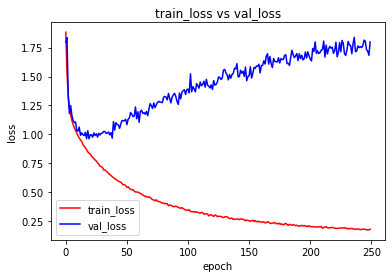

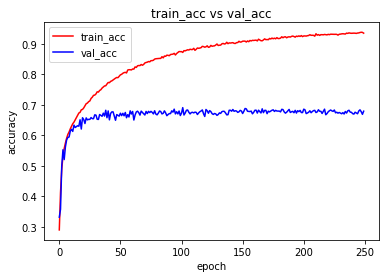

<Figure size 432x288 with 0 Axes>

In [28]:
# visualizing losses and accuracy
%matplotlib inline

train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.figure()

In [0]:
model.save('/content/drive/My Drive/DL-Assignment-2/fer2013.h5')

In [31]:
loss = model.evaluate(test_flow, steps = len(X_test)/ batch_size)
print(f'Test accuracy : {loss[1]*100}%')

57/56 [==============================] - 1s 15ms/step - loss: 1.6252 - accuracy: 0.6854
Test accuracy : 68.5427725315094%


In [0]:
def plot_confusion_matrix(y_test, y_pred, classes, normalize=False, title='Unnormalized confusion matrix', cmap=plt.cm.Blues):
  cm = confusion_matrix(y_test, y_pred)
    
  if normalize:
    cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
      
  np.set_printoptions(precision=2)
      
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  thresh = cm.min() + (cm.max() - cm.min()) / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True expression')
  plt.xlabel('Predicted expression')
  plt.show()

In [0]:
y_pred_temp = model.predict(X_test/255. , )
y_pred = np.argmax(y_pred_temp, axis=1)
t_te = np.argmax(y_test, axis=1)

In [42]:
classes=np.array(("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"))
classes

array(['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'],
      dtype='<U8')

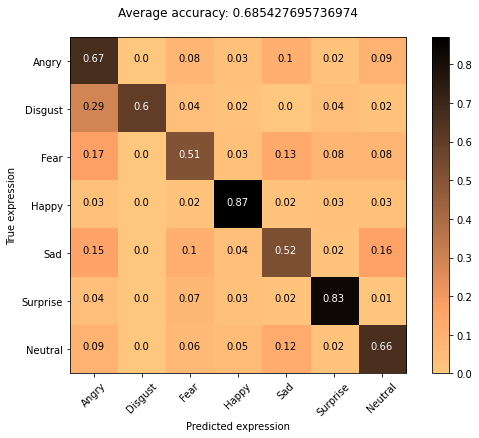

In [54]:
from sklearn.metrics import confusion_matrix
import itertools
plt.figure(figsize=(8,6))
fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred, classes=classes, normalize=True, cmap='copper_r'
, title='Average accuracy: ' + str(np.sum(y_pred == t_te)/len(t_te)) + '\n')